# Import Library & Load Data

In [12]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

In [13]:
# Load the data
df = pd.read_excel('Data_Mahasiswa_Nama_NIM_Fix.xlsx')

# Display basic info
print("="*50)
print("INFORMASI DATASET")
print("="*50)
print(df.info())
print("\nSample data:")
print(df.head())

INFORMASI DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   NIM                                 1000 non-null   int64  
 1   Nama Mahasiswa                      1000 non-null   object 
 2   Jurusan                             1000 non-null   object 
 3   IPK                                 1000 non-null   float64
 4   Jumlah SKS                          1000 non-null   int64  
 5   Nilai Mata Kuliah                   1000 non-null   float64
 6   Jumlah Kehadiran                    1000 non-null   int64  
 7   Jumlah Tugas                        1000 non-null   int64  
 8   Status (Lulus/Tidak)                1000 non-null   object 
 9   Skor Evaluasi Dosen oleh Mahasiswa  1000 non-null   float64
 10  Waktu Lama Studi (semester)         1000 non-null   int64  
dtypes: float64(3), int64(5), o

# Preprocessing Data

In [14]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Drop unnecessary columns (NIM dan Nama Mahasiswa tidak diperlukan untuk modeling)
df_model = df.drop(['NIM', 'Nama Mahasiswa'], axis=1)

# Convert 'Status (Lulus/Tidak)' to binary (1 for Lulus, 0 for Tidak)
df_model['Status'] = df_model['Status (Lulus/Tidak)'].apply(lambda x: 1 if x == 'Lulus' else 0)
df_model = df_model.drop(['Status (Lulus/Tidak)'], axis=1)

# Encode categorical variables (Jurusan)
label_encoder = LabelEncoder()
df_model['Jurusan'] = label_encoder.fit_transform(df_model['Jurusan'])

# Mapping jurusan
jurusan_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nMapping Jurusan:")
for jurusan, kode in jurusan_mapping.items():
    print(f"{jurusan}: {kode}")


Missing values:
NIM                                   0
Nama Mahasiswa                        0
Jurusan                               0
IPK                                   0
Jumlah SKS                            0
Nilai Mata Kuliah                     0
Jumlah Kehadiran                      0
Jumlah Tugas                          0
Status (Lulus/Tidak)                  0
Skor Evaluasi Dosen oleh Mahasiswa    0
Waktu Lama Studi (semester)           0
dtype: int64

Mapping Jurusan:
Akuntansi: 0
Manajemen: 1
Sistem Informasi: 2
Teknik Elektro: 3
Teknik Informatika: 4


# Visualization Data

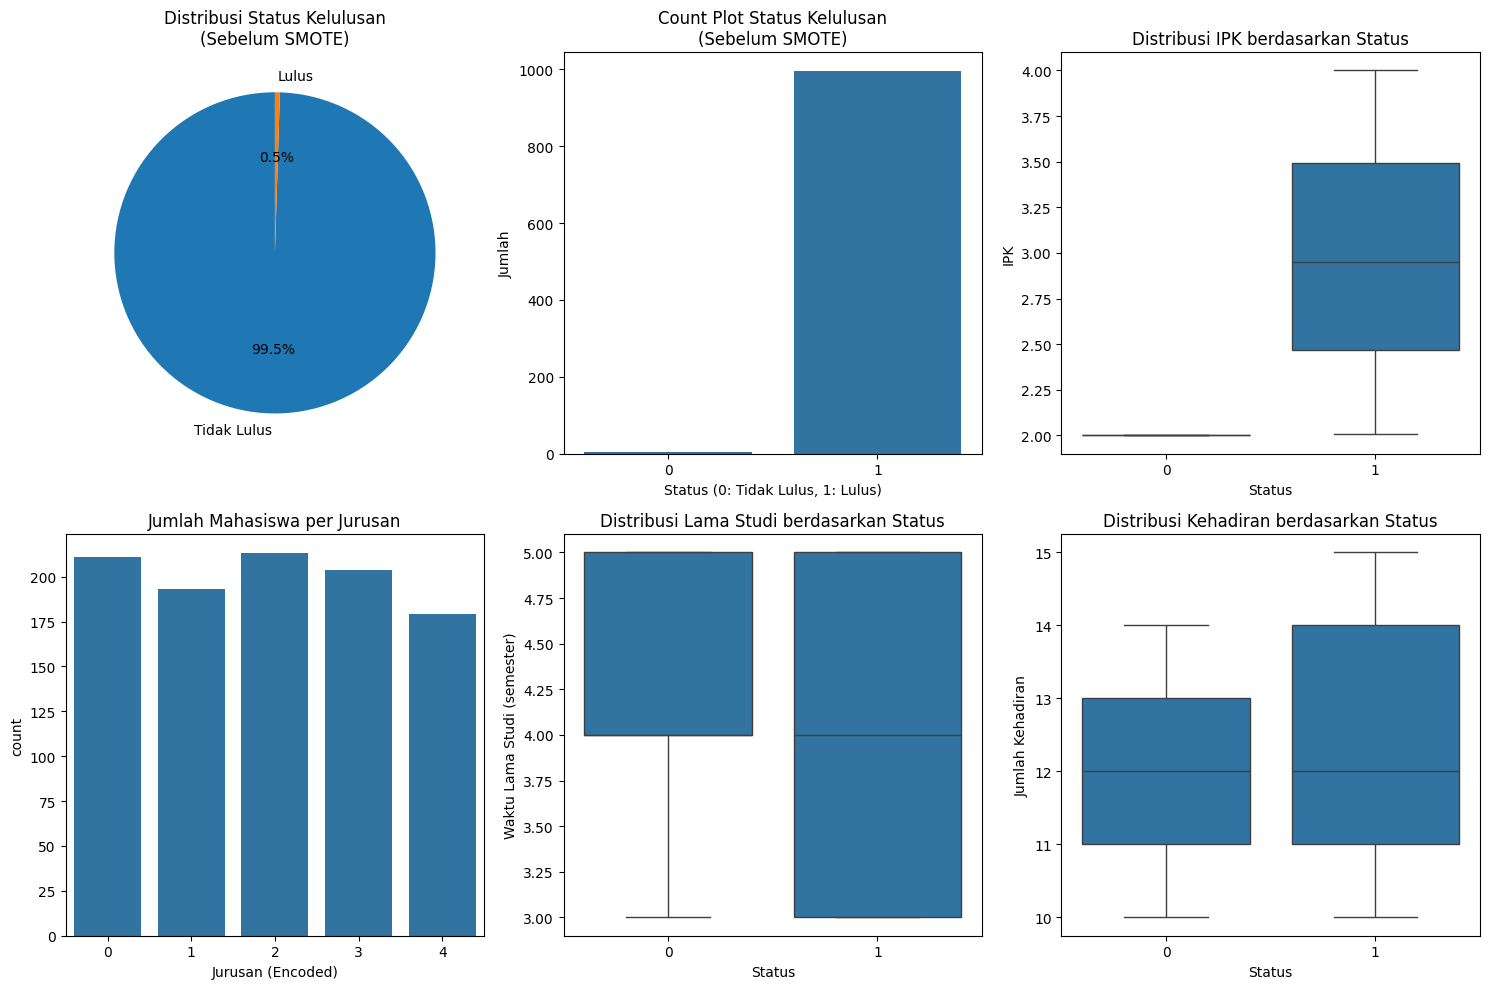

Distribusi data SEBELUM SMOTE:
Tidak Lulus (0): 5 (0.5%)
Lulus (1): 995 (99.5%)



In [15]:
# Visualize distribution of target variable BEFORE SMOTE
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
before_counts = df_model['Status'].value_counts()
plt.pie(before_counts.values, labels=['Tidak Lulus', 'Lulus'], autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Status Kelulusan\n(Sebelum SMOTE)')

plt.subplot(2, 3, 2)
sns.countplot(x='Status', data=df_model)
plt.title('Count Plot Status Kelulusan\n(Sebelum SMOTE)')
plt.xlabel('Status (0: Tidak Lulus, 1: Lulus)')
plt.ylabel('Jumlah')

# Distribusi IPK berdasarkan status
plt.subplot(2, 3, 3)
sns.boxplot(x='Status', y='IPK', data=df_model)
plt.title('Distribusi IPK berdasarkan Status')

# Distribusi berdasarkan jurusan
plt.subplot(2, 3, 4)
sns.countplot(x='Jurusan', data=df_model)
plt.title('Jumlah Mahasiswa per Jurusan')
plt.xlabel('Jurusan (Encoded)')

# Distribusi lama studi
plt.subplot(2, 3, 5)
sns.boxplot(x='Status', y='Waktu Lama Studi (semester)', data=df_model)
plt.title('Distribusi Lama Studi berdasarkan Status')

# Distribusi kehadiran
plt.subplot(2, 3, 6)
sns.boxplot(x='Status', y='Jumlah Kehadiran', data=df_model)
plt.title('Distribusi Kehadiran berdasarkan Status')

plt.tight_layout()
plt.show()

print("Distribusi data SEBELUM SMOTE:")
print(f"Tidak Lulus (0): {before_counts[0]} ({before_counts[0]/len(df_model)*100:.1f}%)")
print(f"Lulus (1): {before_counts[1]} ({before_counts[1]/len(df_model)*100:.1f}%)")
print()

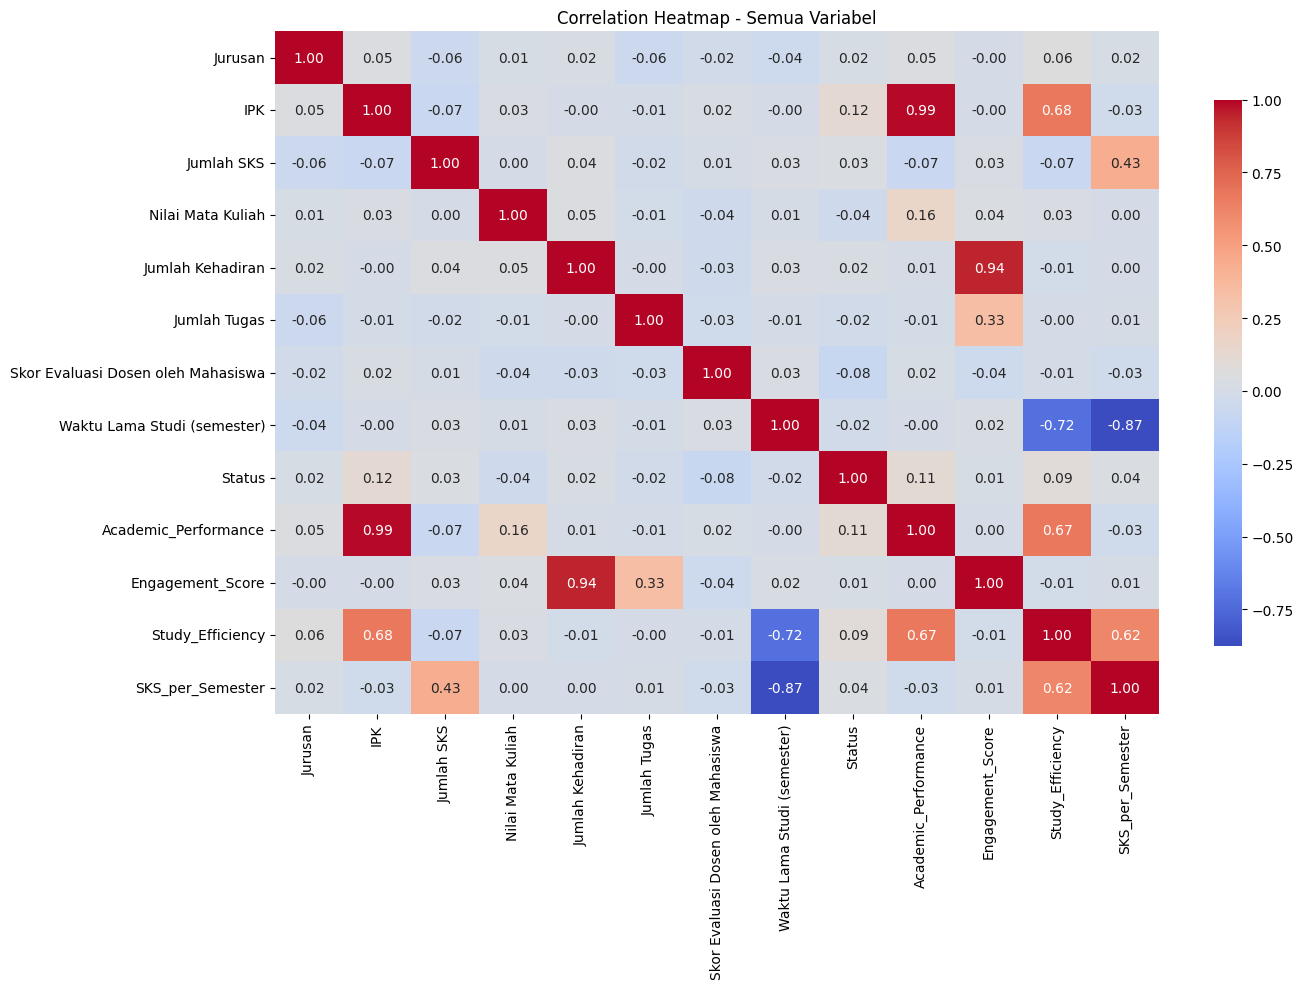

KORELASI DENGAN TARGET (STATUS)
Status                                1.000000
IPK                                   0.120140
Academic_Performance                  0.113549
Study_Efficiency                      0.090094
SKS_per_Semester                      0.036102
Jumlah SKS                            0.033567
Jumlah Kehadiran                      0.020518
Jurusan                               0.017596
Engagement_Score                      0.011983
Waktu Lama Studi (semester)          -0.018688
Jumlah Tugas                         -0.022005
Nilai Mata Kuliah                    -0.038229
Skor Evaluasi Dosen oleh Mahasiswa   -0.082322
Name: Status, dtype: float64


In [19]:
# Correlation heatmap
plt.figure(figsize=(14,10))
sns.heatmap(df_model.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap - Semua Variabel')
plt.tight_layout()
plt.show()

# Analisis korelasi dengan target
print("="*50)
print("KORELASI DENGAN TARGET (STATUS)")
print("="*50)
correlations = df_model.corr()['Status'].sort_values(ascending=False)
print(correlations)

# Feature Engineering

In [21]:
# Buat fitur baru
print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

# 1. Academic Performance Score (gabungan IPK dan Nilai Mata Kuliah)
df_model['Academic_Performance'] = (df_model['IPK'] * 0.6) + (df_model['Nilai Mata Kuliah'] * 0.4 / 100)

# 2. Engagement Score (gabungan kehadiran dan tugas)
df_model['Engagement_Score'] = (df_model['Jumlah Kehadiran'] * 0.7) + (df_model['Jumlah Tugas'] * 0.3)

# 3. Efficiency Score (IPK dibagi lama studi)
df_model['Study_Efficiency'] = df_model['IPK'] / df_model['Waktu Lama Studi (semester)']

# 4. SKS per semester
df_model['SKS_per_Semester'] = df_model['Jumlah SKS'] / df_model['Waktu Lama Studi (semester)']

print("Fitur baru yang dibuat:")
print("1. Academic_Performance: Kombinasi IPK dan Nilai Mata Kuliah")
print("2. Engagement_Score: Kombinasi Kehadiran dan Tugas")
print("3. Study_Efficiency: IPK dibagi lama studi")
print("4. SKS_per_Semester: Jumlah SKS dibagi lama studi")

# Define features dan target
X = df_model.drop(['Status'], axis=1)
y = df_model['Status']

print(f"\nJumlah fitur: {X.shape[1]}")
print("Daftar fitur:")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")


FEATURE ENGINEERING
Fitur baru yang dibuat:
1. Academic_Performance: Kombinasi IPK dan Nilai Mata Kuliah
2. Engagement_Score: Kombinasi Kehadiran dan Tugas
3. Study_Efficiency: IPK dibagi lama studi
4. SKS_per_Semester: Jumlah SKS dibagi lama studi

Jumlah fitur: 12
Daftar fitur:
 1. Jurusan
 2. IPK
 3. Jumlah SKS
 4. Nilai Mata Kuliah
 5. Jumlah Kehadiran
 6. Jumlah Tugas
 7. Skor Evaluasi Dosen oleh Mahasiswa
 8. Waktu Lama Studi (semester)
 9. Academic_Performance
10. Engagement_Score
11. Study_Efficiency
12. SKS_per_Semester


# Imbalance Data


PENERAPAN SMOTE
Distribusi data training SEBELUM SMOTE:
Counter({1: 697, 0: 3})

Distribusi data training SESUDAH SMOTE:
Counter({1: 697, 0: 697})


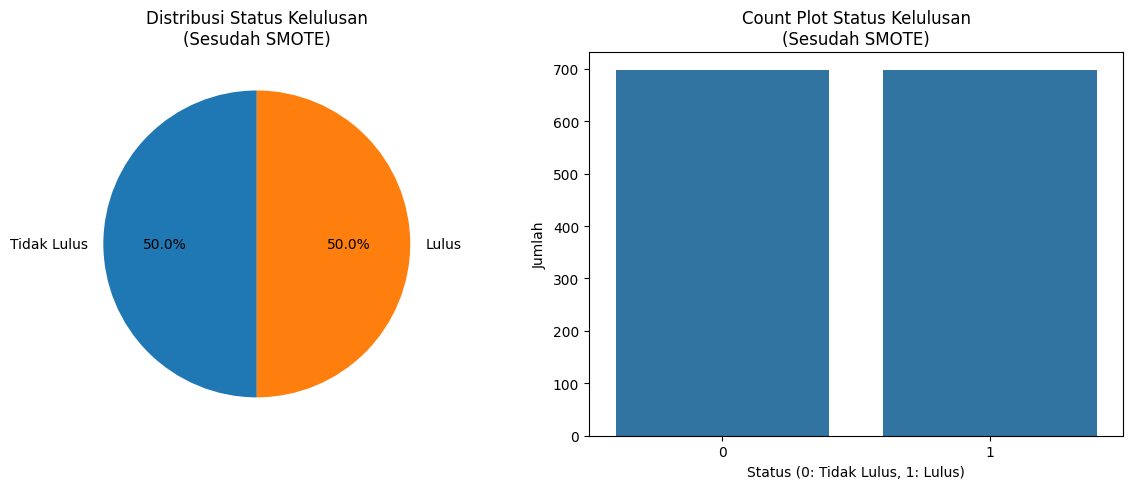


Perbandingan Distribusi:
SEBELUM SMOTE - Tidak Lulus: 3, Lulus: 697
SESUDAH SMOTE - Tidak Lulus: 697, Lulus: 697


In [23]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE for handling imbalanced data
print("\n" + "="*50)
print("PENERAPAN SMOTE")
print("="*50)
print("Distribusi data training SEBELUM SMOTE:")
print(Counter(y_train))

# Fix: Set k_neighbors to be less than or equal to the number of minority samples
# The minority class has 3 samples, so k_neighbors must be <= 3. Let's set it to 2.
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nDistribusi data training SESUDAH SMOTE:")
print(Counter(y_train_balanced))

# Visualize distribution AFTER SMOTE
plt.figure(figsize=(12, 5))

# Create temporary dataframe for visualization
temp_df = pd.DataFrame()
temp_df['Status'] = y_train_balanced
after_counts = temp_df['Status'].value_counts()

plt.subplot(1, 2, 1)
plt.pie(after_counts.values, labels=['Tidak Lulus', 'Lulus'], autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Status Kelulusan\n(Sesudah SMOTE)')

plt.subplot(1, 2, 2)
sns.countplot(x='Status', data=temp_df)
plt.title('Count Plot Status Kelulusan\n(Sesudah SMOTE)')
plt.xlabel('Status (0: Tidak Lulus, 1: Lulus)')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

print(f"\nPerbandingan Distribusi:")
print(f"SEBELUM SMOTE - Tidak Lulus: {len(y_train[y_train==0])}, Lulus: {len(y_train[y_train==1])}")
print(f"SESUDAH SMOTE - Tidak Lulus: {len(y_train_balanced[y_train_balanced==0])}, Lulus: {len(y_train_balanced[y_train_balanced==1])}")

# Init Model

In [24]:
# Initialize and train Random Forest with balanced data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred = rf.predict(X_test)


HASIL EVALUASI MODEL
Accuracy: 0.9966666666666667

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00       298

    accuracy                           1.00       300
   macro avg       1.00      0.75      0.83       300
weighted avg       1.00      1.00      1.00       300



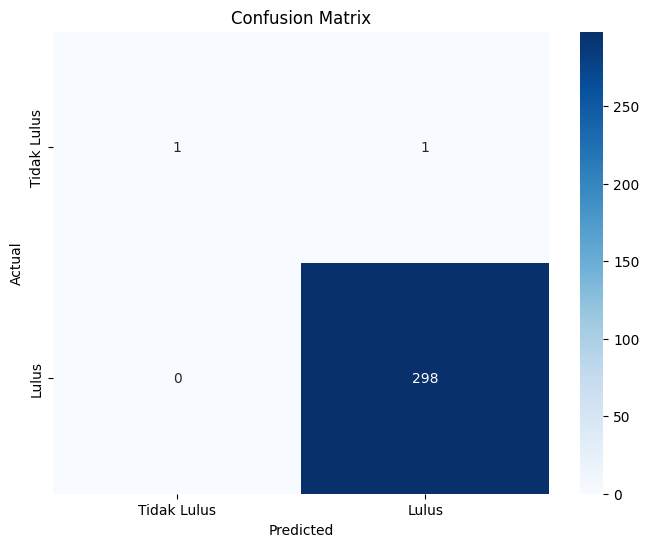

In [25]:
# Evaluation metrics
print("\n" + "="*50)
print("HASIL EVALUASI MODEL")
print("="*50)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Tidak Lulus', 'Lulus'],
            yticklabels=['Tidak Lulus', 'Lulus'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

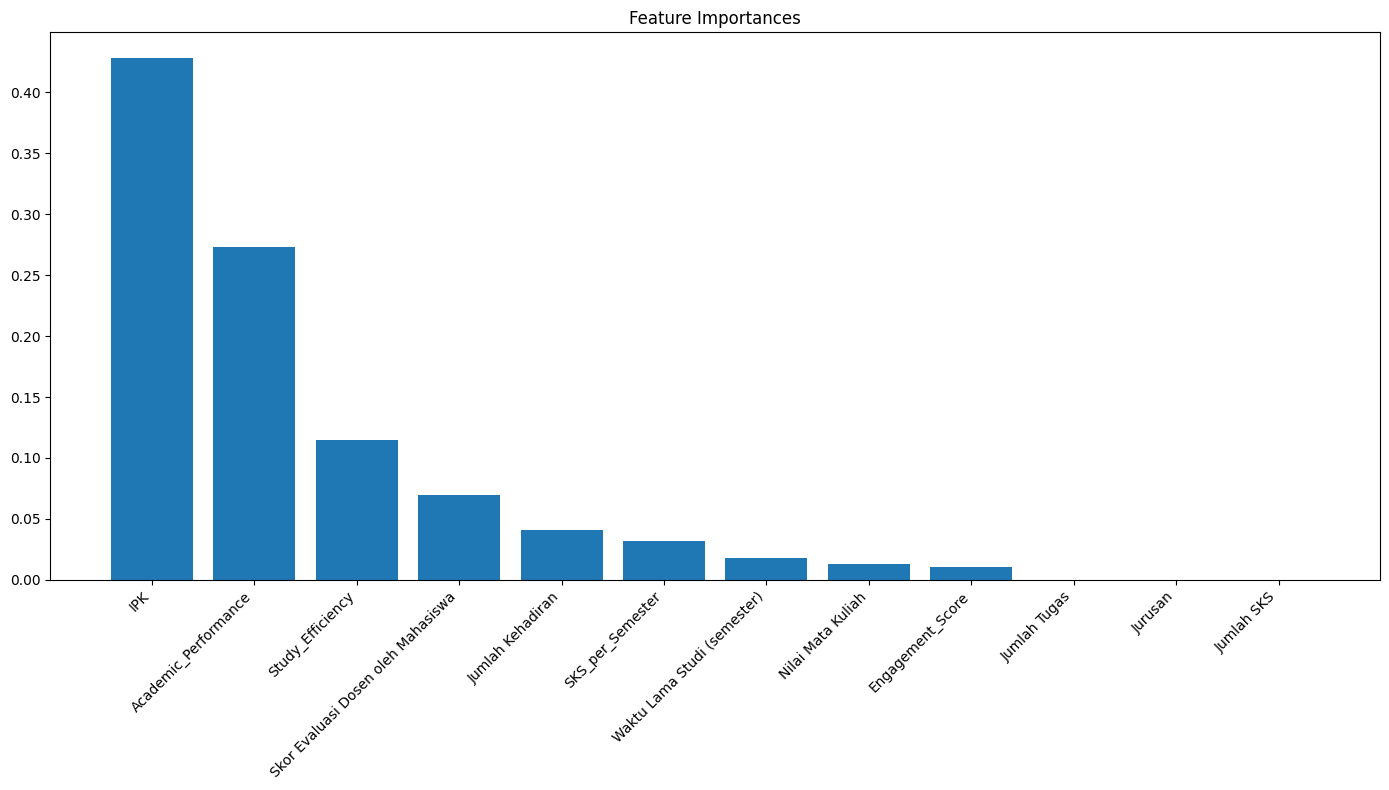


Top 10 Fitur Paling Penting:
 1. IPK: 0.4278
 2. Academic_Performance: 0.2730
 3. Study_Efficiency: 0.1146
 4. Skor Evaluasi Dosen oleh Mahasiswa: 0.0694
 5. Jumlah Kehadiran: 0.0410
 6. SKS_per_Semester: 0.0320
 7. Waktu Lama Studi (semester): 0.0179
 8. Nilai Mata Kuliah: 0.0130
 9. Engagement_Score: 0.0107
10. Jumlah Tugas: 0.0002


In [26]:
# Get feature importances
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(14,8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print top 10 most important features
print("\nTop 10 Fitur Paling Penting:")
for i in range(min(10, len(features))):
    print(f"{i+1:2d}. {features[indices[i]]}: {importances[indices[i]]:.4f}")

from sklearn.model_selection import GridSearchCV

In [29]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("\n" + "="*50)
print("GRID SEARCH OPTIMIZATION")
print("="*50)

# Grid search with balanced data
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_balanced, y_train_balanced)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Evaluate best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("Improved Accuracy:", accuracy_score(y_test, y_pred_best))


GRID SEARCH OPTIMIZATION
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Score: 1.0
Improved Accuracy: 0.9966666666666667


# Prediksi Data Baru

In [30]:
print("\n" + "="*50)
print("PREDIKSI DATA BARU")
print("="*50)

# Contoh data baru untuk prediksi
feature_names = X.columns.tolist()
print("Fitur yang digunakan dalam model:")
for i, feature in enumerate(feature_names):
    print(f"{i+1:2d}. {feature}")

# Contoh data baru (sesuaikan dengan struktur data Anda)
data_baru = {
    'Jurusan': [1],  # Encoded jurusan
    'IPK': [3.5],
    'Jumlah SKS': [144],
    'Nilai Mata Kuliah': [85],
    'Jumlah Kehadiran': [95],
    'Jumlah Tugas': [20],
    'Skor Evaluasi Dosen oleh Mahasiswa': [4.2],
    'Waktu Lama Studi (semester)': [8],
    'Academic_Performance': [(3.5 * 0.6) + (85 * 0.4 / 100)],
    'Engagement_Score': [(95 * 0.7) + (20 * 0.3)],
    'Study_Efficiency': [3.5 / 8],
    'SKS_per_Semester': [144 / 8]
}

# Buat DataFrame untuk data baru
df_baru = pd.DataFrame(data_baru)

# Prediksi
prediksi = best_rf.predict(df_baru)
probabilitas = best_rf.predict_proba(df_baru)

print(f"\nData baru untuk prediksi:")
for feature, value in data_baru.items():
    print(f"{feature}: {value[0]}")

print(f"\nHasil Prediksi:")
if prediksi[0] == 1:
    print("Status: LULUS")
else:
    print("Status: TIDAK LULUS")

print(f"\nProbabilitas:")
print(f"Probabilitas Tidak Lulus: {probabilitas[0][0]:.3f} ({probabilitas[0][0]*100:.1f}%)")
print(f"Probabilitas Lulus: {probabilitas[0][1]:.3f} ({probabilitas[0][1]*100:.1f}%)")


PREDIKSI DATA BARU
Fitur yang digunakan dalam model:
 1. Jurusan
 2. IPK
 3. Jumlah SKS
 4. Nilai Mata Kuliah
 5. Jumlah Kehadiran
 6. Jumlah Tugas
 7. Skor Evaluasi Dosen oleh Mahasiswa
 8. Waktu Lama Studi (semester)
 9. Academic_Performance
10. Engagement_Score
11. Study_Efficiency
12. SKS_per_Semester

Data baru untuk prediksi:
Jurusan: 1
IPK: 3.5
Jumlah SKS: 144
Nilai Mata Kuliah: 85
Jumlah Kehadiran: 95
Jumlah Tugas: 20
Skor Evaluasi Dosen oleh Mahasiswa: 4.2
Waktu Lama Studi (semester): 8
Academic_Performance: 2.44
Engagement_Score: 72.5
Study_Efficiency: 0.4375
SKS_per_Semester: 18.0

Hasil Prediksi:
Status: LULUS

Probabilitas:
Probabilitas Tidak Lulus: 0.010 (1.0%)
Probabilitas Lulus: 0.990 (99.0%)


In [35]:
# Fungsi untuk prediksi data baru yang lebih user-friendly
def prediksi_mahasiswa(jurusan_encoded, ipk, jumlah_sks, nilai_mk, kehadiran,
                      tugas, skor_evaluasi, lama_studi):
    """
    Fungsi untuk memprediksi status kelulusan mahasiswa baru

    Parameters:
    jurusan_encoded (int): Kode jurusan yang sudah di-encode
    ipk (float): IPK mahasiswa
    jumlah_sks (int): Total SKS yang diambil
    nilai_mk (float): Nilai mata kuliah rata-rata
    kehadiran (int): Jumlah kehadiran
    tugas (int): Jumlah tugas yang dikerjakan
    skor_evaluasi (float): Skor evaluasi dosen oleh mahasiswa
    lama_studi (int): Lama studi dalam semester

    Returns:
    dict: Hasil prediksi dan probabilitas
    """
    # Hitung fitur engineered
    academic_performance = (ipk * 0.6) + (nilai_mk * 0.4 / 100)
    engagement_score = (kehadiran * 0.7) + (tugas * 0.3)
    study_efficiency = ipk / lama_studi
    sks_per_semester = jumlah_sks / lama_studi

    # Buat data untuk prediksi
    data_prediksi = pd.DataFrame({
        'Jurusan': [jurusan_encoded],
        'IPK': [ipk],
        'Jumlah SKS': [jumlah_sks],
        'Nilai Mata Kuliah': [nilai_mk],
        'Jumlah Kehadiran': [kehadiran],
        'Jumlah Tugas': [tugas],
        'Skor Evaluasi Dosen oleh Mahasiswa': [skor_evaluasi],
        'Waktu Lama Studi (semester)': [lama_studi],
        'Academic_Performance': [academic_performance],
        'Engagement_Score': [engagement_score],
        'Study_Efficiency': [study_efficiency],
        'SKS_per_Semester': [sks_per_semester]
    })

    # Prediksi
    prediksi = best_rf.predict(data_prediksi)[0]
    probabilitas = best_rf.predict_proba(data_prediksi)[0]

    hasil = {
        'prediksi': 'LULUS' if prediksi == 1 else 'TIDAK LULUS',
        'probabilitas_tidak_lulus': probabilitas[0],
        'probabilitas_lulus': probabilitas[1],
        'confidence': max(probabilitas),
        'academic_performance': academic_performance,
        'engagement_score': engagement_score,
        'study_efficiency': study_efficiency,
        'sks_per_semester': sks_per_semester
    }

    return hasil

# Contoh penggunaan fungsi prediksi
print("\n" + "="*50)
print("CONTOH PENGGUNAAN FUNGSI PREDIKSI")
print("="*50)

# Contoh prediksi untuk beberapa mahasiswa
contoh_mahasiswa = [
    {
        'jurusan': 0, 'ipk': 3.8, 'sks': 144, 'nilai_mk': 90,
        'kehadiran': 98, 'tugas': 25, 'evaluasi': 4.5, 'lama_studi': 8
    },
    {
        'jurusan': 1, 'ipk': 2.5, 'sks': 144, 'nilai_mk': 70,
        'kehadiran': 75, 'tugas': 15, 'evaluasi': 3.5, 'lama_studi': 10
    },
    {
        'jurusan': 2, 'ipk': 3.2, 'sks': 144, 'nilai_mk': 80,
        'kehadiran': 85, 'tugas': 20, 'evaluasi': 4.0, 'lama_studi': 9
    }
]

for i, mhs in enumerate(contoh_mahasiswa, 1):
    hasil = prediksi_mahasiswa(
        mhs['jurusan'], mhs['ipk'], mhs['sks'], mhs['nilai_mk'],
        mhs['kehadiran'], mhs['tugas'], mhs['evaluasi'], mhs['lama_studi']
    )

    print(f"\nMahasiswa {i}:")
    print(f"  Jurusan (encoded): {mhs['jurusan']}")
    print(f"  IPK: {mhs['ipk']}")
    print(f"  Jumlah SKS: {mhs['sks']}")
    print(f"  Nilai Mata Kuliah: {mhs['nilai_mk']}")
    print(f"  Kehadiran: {mhs['kehadiran']}")
    print(f"  Jumlah Tugas: {mhs['tugas']}")
    print(f"  Skor Evaluasi: {mhs['evaluasi']}")
    print(f"  Lama Studi: {mhs['lama_studi']} semester")
    print(f"  Prediksi: {hasil['prediksi']}")
    print(f"  Confidence: {hasil['confidence']:.3f} ({hasil['confidence']*100:.1f}%)")
    print(f"  Academic Performance: {hasil['academic_performance']:.3f}")
    print(f"  Study Efficiency: {hasil['study_efficiency']:.3f}")


CONTOH PENGGUNAAN FUNGSI PREDIKSI

Mahasiswa 1:
  Jurusan (encoded): 0
  IPK: 3.8
  Jumlah SKS: 144
  Nilai Mata Kuliah: 90
  Kehadiran: 98
  Jumlah Tugas: 25
  Skor Evaluasi: 4.5
  Lama Studi: 8 semester
  Prediksi: LULUS
  Confidence: 0.990 (99.0%)
  Academic Performance: 2.640
  Study Efficiency: 0.475

Mahasiswa 2:
  Jurusan (encoded): 1
  IPK: 2.5
  Jumlah SKS: 144
  Nilai Mata Kuliah: 70
  Kehadiran: 75
  Jumlah Tugas: 15
  Skor Evaluasi: 3.5
  Lama Studi: 10 semester
  Prediksi: LULUS
  Confidence: 1.000 (100.0%)
  Academic Performance: 1.780
  Study Efficiency: 0.250

Mahasiswa 3:
  Jurusan (encoded): 2
  IPK: 3.2
  Jumlah SKS: 144
  Nilai Mata Kuliah: 80
  Kehadiran: 85
  Jumlah Tugas: 20
  Skor Evaluasi: 4.0
  Lama Studi: 9 semester
  Prediksi: LULUS
  Confidence: 0.990 (99.0%)
  Academic Performance: 2.240
  Study Efficiency: 0.356


In [36]:
# Analisis fitur penting untuk interpretasi model
print("\n" + "="*50)
print("INTERPRETASI MODEL")
print("="*50)

# Feature importance analysis
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Ranking Kepentingan Fitur:")
for idx, row in feature_importance_df.iterrows():
    print(f"{feature_importance_df.index.get_loc(idx)+1:2d}. {row['Feature']}: {row['Importance']:.4f}")


INTERPRETASI MODEL
Ranking Kepentingan Fitur:
 1. IPK: 0.4278
 2. Academic_Performance: 0.2730
 3. Study_Efficiency: 0.1146
 4. Skor Evaluasi Dosen oleh Mahasiswa: 0.0694
 5. Jumlah Kehadiran: 0.0410
 6. SKS_per_Semester: 0.0320
 7. Waktu Lama Studi (semester): 0.0179
 8. Nilai Mata Kuliah: 0.0130
 9. Engagement_Score: 0.0107
10. Jumlah Tugas: 0.0002
11. Jurusan: 0.0002
12. Jumlah SKS: 0.0001


In [37]:
# Save model dan encoder
import pickle
from google.colab import files

print("\n" + "="*50)
print("MENYIMPAN MODEL")
print("="*50)

# Save the trained model to a file
model_filename = 'random_forest_graduation_model.pkl'
pickle.dump(best_rf, open(model_filename, 'wb'))

# Save label encoder
encoder_filename = 'jurusan_label_encoder.pkl'
pickle.dump(label_encoder, open(encoder_filename, 'wb'))

# Save feature names
feature_filename = 'feature_names.pkl'
pickle.dump(list(X.columns), open(feature_filename, 'wb'))

# Save jurusan mapping
mapping_filename = 'jurusan_mapping.pkl'
pickle.dump(jurusan_mapping, open(mapping_filename, 'wb'))

# Download the files
files.download(model_filename)
files.download(encoder_filename)
files.download(feature_filename)
files.download(mapping_filename)

print(f"File yang disimpan:")
print(f"1. Model: {model_filename}")
print(f"2. Label Encoder: {encoder_filename}")
print(f"3. Feature Names: {feature_filename}")
print(f"4. Jurusan Mapping: {mapping_filename}")

print("\n" + "="*50)
print("SELESAI!")
print("="*50)
print("Model telah berhasil dilatih dan siap digunakan untuk prediksi status kelulusan mahasiswa.")


MENYIMPAN MODEL


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File yang disimpan:
1. Model: random_forest_graduation_model.pkl
2. Label Encoder: jurusan_label_encoder.pkl
3. Feature Names: feature_names.pkl
4. Jurusan Mapping: jurusan_mapping.pkl

SELESAI!
Model telah berhasil dilatih dan siap digunakan untuk prediksi status kelulusan mahasiswa.
